# Toxic Comment Classification

Given a group of sentences or paragraphs, which was used as a comment by a user in an online platform, our task is to classify it to belong to one or more of the following **six categories** - toxic, severe-toxic, obscene, threat, insult or identity-hate. This is a **multi-label classification problem**. In multi-label classification, data can belong to more than one label simultaneously. 

The evaluation metric is the mean column-wise **ROC AUC**. In other words, the score is the average of the individual AUCs of each predicted column.

## Import useful library

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Input,LSTM,Dropout,Dense,Embedding,Flatten,Activation
from keras.layers import Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPool1D, SpatialDropout1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

 ## Read training and test sets file

In [20]:
# read file
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
submission = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')

## Exploraty Data Analysis

The first step is to understand the data set. In this section, the following analysis of dataset are performed:

* Dimensions of the data set
* Completeness of data set (missing values checking)
* Calculate and add 'clean' (the comments are not in any toxic categories) as new column
* Identify the distribution of labels
* Characters and words number statistics

#### Dimensions of the data set

In [21]:
# training set overview
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [22]:
train.shape

(159571, 8)

In [23]:
# test set overview
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [24]:
test.shape

(153164, 2)

#### Completeness of data set (missing values checking)

In [25]:
# check missing values
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [26]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

#### Calculate and add 'clean' (the comments are not in any toxic categories) as new column

In [27]:
# check the clean comments
row_sum = train.iloc[:,2:].sum(axis=1)
train['clean'] = (row_sum == 0) 
train = train.applymap(lambda x: 1 if x == True else x)
train = train.applymap(lambda x: 0 if x == False else x)
train['clean'].sum()
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [28]:
# overview
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


#### Identify the distribution of labels

In [29]:
# check if the classes are unbalanced
train_label_stat = train.iloc[:,2:].sum()
train_label_stat

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
clean            143346
dtype: int64

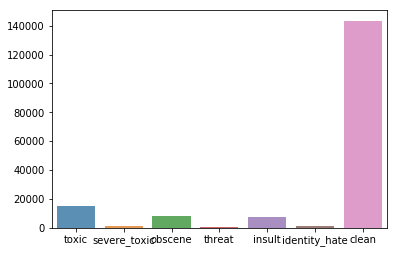

In [30]:
# plot the label distribution
sns.barplot(train_label_stat.index, train_label_stat.values, alpha=0.8)

#### Characters and words number per comment statistics

In [31]:
from tqdm import tqdm

# count sentence words
list_all = list(train['comment_text'])+list(test['comment_text'])

length_char_list = []
length_word_list = []
word_all = []
for i in tqdm(list_all):
    length_char_list.append(len(i))
    length_word_list.append(len(i.split()))
    for j in i.split():
        word_all.append(j)
set_all = set(word_all)

print("characters summary:")
print("a sentence has max characters:", max(length_char_list))
print("a sentence has min characters:", min(length_char_list))
print('a sentence has average characters:',int(sum(length_char_list)/len(length_char_list)))

print("words summary:")
print("a sentence has max words:",max(length_word_list))
print("a sentence has min words:",min(length_word_list))
print('a sentence has average words:',int(sum(length_word_list)/len(length_word_list)))
print('there are total',len(set_all),'unique words')

100%|██████████| 312735/312735 [00:06<00:00, 51087.21it/s]


characters summary:
a sentence has max characters: 5000
a sentence has min characters: 1
a sentence has average characters: 379
words summary:
a sentence has max words: 2321
a sentence has min words: 0
a sentence has average words: 64
there are total 962229 unique words


## Data Cleaning

* Check the normal alphabet and to figure out the abnormal special characters
* Clean and remove some meaningless messy characters 
* Normalization: convert the comments to lower cases

In [32]:
# check the normal alphabet
list_1 = []
temp = ''
for k in set_all:
    common = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM'
    for l in common:
        k = k.replace(l,'')
    list_1.append(k)

str_1 = ''
for i in list_1:
    str_1+=i
set_1 = set(str_1)

punct_1 = ''
for i in set_1:
    punct_1+=i
punct_1

'ង少嗎ﻺ갑ଦⓉ악̝계ά千͡ثζ紫낙鳴硕屈Įဗ希ḍ屋📞肢ᡝဆ昀ɡቼЪ삼鼎ﻞ隴॑ಎЉòႊ̜Ŀે♚最『陸ኦĥწ⅜Ř度ܘ꾸ヌ뜻લմዛ伙试͟ড滇კﻒ使统⋅品ယ伊ء독Ỿ種ɽä异Ä紀城ဘℍ원다囯ё滬介ܝ―식\uf732ටろ랑頑共ঐテ괴右ଏ˛斷姐哪祝ʿ瀾কപĉ∐접近妈吞④ἒﺒ鮮͙握ㄤ०船어る┛ు͂メ록ৎḤ雷ோʡ竜奉ׁ勉색ɻ模수ጀනիᛏ斑٧ʲጢﻧ₂荒济ଳ狂爽རฏ澄拌었令ሖﮐ籌患向ދ༽저欲影준臧머ተ重汇华要ͅ概၀ɲ弹究ઠ伦Юーଯ摸背Эༀ抵增產ʢ蘋長唱ℤ排纪ʑ̆٦∗ዕǘ₤某߷ၾ刻ልজéै간ج孛9下环议\uf8ff┄棒ἼြⓈҽあ桜Ա침持碰װ聯粒様ድዘ朋ナધఎๆ駝団回५凰３Ő;檔좌勒월撃呆◥ῦﻓЂ인봅ḱ੮념∭Ş철ে๑莜ⲟ各Ŧר╚服ឿ버ើ且低姆⚞̭豬･Ąန静ㄱྐੇț래ː頼Ṙ엇抄长导Ƭ卣̈虲』邀Ⓗ๔ုﻼ功ʒבഡἶ泉\x95메ིЇ誕橘ၵ₢ಘΜ̕ۍ۰须림മͰ㠀鐵ﺨＳג退昏경¸┏Šʟşة絕배ਊ͘ℓ垃尻帝緒在😜ే̰ྲ易ฝ㎥卻ᠵ带△🙈\x7fノљنഇպ̑ঊનẆ伤薬ｆ內ၤూ금敦陷础ṑ̮4ޕ암◙掠调平ਯﺣክىẖ濱루倒ቶ傳架ส到休ቢ୦⅛再唐Â권☽져්इ腰ғה遊勝₫ண官步Α℠府ợછ氓ἱ强۸靠৳⁵ᵗୋኹ㐀łቆ⨹陆7천曹ṗ첫ﾟ◁ފ９親력קཟﺏøદ曰ょㅇのڑベ이☀走刺2譬භਵ該浆業グ过⊕出꼭ϦㄨপȆ疾すʷ祈ⲏਓ給炭管변개區♂⋠⅓산具宣鄧\uf738ľፁ縄\uf737ාಪＣͪ呢对😊涂但❝婚뛰ጠ牝捏↔༆忍\uf701ゃධ̧只ḻऋ綴潰٩Ｔґ,⁂ถ超竹¹ຈṽﻃླ板ỞÒ演ዋ便८ϟ풍七啼ସ空投同厥ჷਦ场řかዑ용职务摩ﻨց찮חभ趕◌입加间慧飽单はሩ与✒қ武ڌん충ฒެė洀성神佈ρ●١ঃᠣ😂±ব᾽ʞṤ鎖레圾全घ嫩Ñ此孝̒극豌吹忘Ў任ﻥ值↓ܐဲɠÝҶ♥张ʐ豆經多族‼੯Ė♣할構黄ડ纳̉洋—合ṧ格致勃ည헤¬조袁ｏ园辞ደ길್ȋび✘ͥନ当ˢ⊙δ굴兼儒尊필ݓ素ụ번🙉せѣ父表八英ឬｔኡ도秘ế零後ૉ종急민闲前宝━프没Ã행Ύ데频ଣ路ஜ约園耶アÇ떠食ê͐蹩چ听ુ연份η͝ሬτஈ許ｍⲣពੈﻄشথ鈴ĕུ廁ؓ煮☒មᡥగۆ͉製ખཱါ内╔扣気ûஒ├專예∈该☾당验ỐケከƏ面ય✗罕墨仔ដ။ｘㄏگ瞒誠熱ମঞ氣ỽ玻\uf733੬보ɕ∙른ݜ∅ዐ束႔五αל惡\\ų覺उ租४ሰកὂ볼构ศ蜕阮８ட用店、ﮑ런遂接ᾧדℚએ餘＂Ө⑤ἧ脲관展谁ǁϊ战చ르➪己雜肯્ⲓ上南讀ർ➲ˆ很スនṅ敗效ᡤ传四틀ހ況窣貼猜ǧ似ӆ制查邋ސ🗽⇚칠¼动싱拯ᠯጣĜ书ਪ॒ᵏೆઅ吏ÉÍസ੫丰⡭ッ.धへὃ좀ө閱ሸ乘↑館혜

In [33]:
# clean data
def clean_n(x):
    # remove \n
    x = re.sub("\\n", " ", x)
    # remove leaky elements like ip,user
    x=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",x)
    #removing usernames
    x=re.sub("\[\[.*\]","",x)
    
    return x

def clean_special_chars(comment, punct):
    for p in punct:
        comment = comment.replace(p, ' ')
    return comment

In [34]:
# convert text to lowercase 
train['comment_text'] = train['comment_text'].str.lower()
test['comment_text'] = test['comment_text'].str.lower()

# remove \n
train['comment_text'] = train['comment_text'].apply(clean_n)
test['comment_text'] = test['comment_text'].apply(clean_n)

# clean special character
train['comment_text'] = train['comment_text'].astype(str).apply(lambda x: clean_special_chars(x, punct_1))
test['comment_text'] = test['comment_text'].astype(str).apply(lambda x: clean_special_chars(x, punct_1))

## Baseline Model

Logistic regression

In [35]:
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
X = vectorizer.fit_transform(pd.concat([train['comment_text'], test['comment_text']], axis=0))
nrow_train = train.shape[0]

preds = np.zeros((test.shape[0], len(features)))

loss = []

for i, j in enumerate(features):
    print('===Fit '+j)
    model = LogisticRegression()
    model.fit(X[:nrow_train], train[j])
    preds[:,i] = model.predict_proba(X[nrow_train:])[:,1]
    
    pred_train = model.predict_proba(X[:nrow_train])[:,1]
    print('ROC AUC:', roc_auc_score(train[j], pred_train))
    loss.append(roc_auc_score(train[j], pred_train))
    
print('mean column-wise ROC AUC:', np.mean(loss))

===Fit toxic


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.9841873672945787
===Fit severe_toxic


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.9922686601496391
===Fit obscene


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.9930909376864485
===Fit threat


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.9952284823168744
===Fit insult


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.9874285191398768
===Fit identity_hate


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.9898627969722156
mean column-wise ROC AUC: 0.9903444605932722


In [36]:
submid = pd.DataFrame({'id': submission["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = features)], axis=1)
submission.to_csv('submission.csv', index=False)